#LeNet Architecture:

<img src="https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/lenet-5.png">


<img src="https://i.sstatic.net/vD1u3.png">

- Input: 1x32x32
- Layer 1 (Convolutional): kernel = 5x5, stride = 1, padding = 0, in channel = 1, out channel = 6, size = 28x28
- Layer 2 (Pooling): Avg pool, k=2x2, s=2, p=0, i=6, o=6, size = 14x14
- Layer 3 (C): K = 5x5, s=1, p=0, i=6, o=16, size = 10x10
- Layer 4 (P): Avg pool, s=2, p=0, i=16, o=16, size = 5x5
- Layer 5 (C): K=5x5, s=1, p=0, i=16,  o=120, size= 1x1
- Layer 6 (Fully Connected): Linear, input = 120, output = 84
- Layer 7 (F): Linear, input = 84, output = 10

#Importing Libraries:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

#Transforming Data:

In [2]:
#Converting FashionMNIST images into 4D tensors [no. of images, height, width, color channel]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)), #Fashion MNIST images are 28x28, LeNet takes a 32x32 input
    transforms.RandomRotation(10),  # Random rotation up to 10 degrees
    transforms.RandomHorizontalFlip(), # Random horizontal flips
])

In [3]:
#Import Train Data

train_data = datasets.FashionMNIST(
    root='./FashionMNIST_CNN_DATA',
    train=True,
    download=True,
    transform=transform
    ) #downloads MNIST training dataset in root path

print(train_data ) #60000 training examples
print(train_data.data.shape) #shape is 60000x28x28 for grayscale image
np.unique(train_data.targets, return_counts=True) #10 labels, each label contains 6000 examples

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./FashionMNIST_CNN_DATA
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
           )
torch.Size([60000, 28, 28])


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [4]:
#Import Test Data

test_data = datasets.FashionMNIST(
    root='./FashionMNIST_CNN_DATA',
    train=False,
    download=True,
    transform=transform
    )

print(test_data ) #10000 training examples
print(test_data.data.shape) #shape is 10000x28x28 for grayscale image
np.unique(test_data.targets, return_counts=True) #10 labels, each label contains 1000 examples

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./FashionMNIST_CNN_DATA
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
           )
torch.Size([10000, 28, 28])


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [5]:
#Data Loaders:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [6]:
print(len(train_loader.dataset)) #60000 examples
print(len(test_loader.dataset)) #10000 examples
print(len(train_loader)) #60000 / 10 (batch size) = 6000
print(len(test_loader)) #10000 / 10 = 1000

60000
10000
6000
1000


In [7]:
for batch, (x, y) in enumerate(train_loader):
  print(batch + 1) #batch starts from 0
  print(x.shape) #shape of x
  print(y.shape) #shape of y
  break

1
torch.Size([10, 1, 32, 32])
torch.Size([10])


#Convolutional Neural Network:

In [8]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.relu = nn.ReLU()
    self.pool = nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), stride=(1,1))
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=(1,1), padding=(0,0))
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), stride=(1,1), padding=(0,0))
    self.linear1 = nn.Linear(120, 84)
    self.linear2 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = self.relu(self.conv3(x)) #Output: num_examples x 120 x 1 x 1
    x = x.reshape(x.shape[0], -1) #Output: num_examples x 120
    x = self.relu(self.linear1(x))
    x = self.linear2(x)
    return x

In [9]:
model = LeNet()

model

LeNet(
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
)

#Set up Loss and Optimizer:

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Training:

In [11]:
#Training:

epochs = 5
train_losses = []
train_correct = []
start_time = time.time()

for epoch in range(epochs):
  trn_corr = 0
  epoch_loss = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 #Start batches at 1

    y_pred = model(X_train) #predicting values from training set

    loss = criterion(y_pred, y_train) #calculating loss

    predicted = torch.max(y_pred.data, 1)[1]
    #torch.max returns max value = [value, index]
    #storing indexes i.e. [1] in predicted

    batch_corr = (predicted == y_train).sum() #calculates the total no. of correct predictions

    trn_corr += batch_corr
    epoch_loss += loss.item()

    #update parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%600 == 0:
      print(f'Epoch: {epoch+1} / {epochs}, Batch: {b}, Loss: {loss.item():.4f}')

  train_losses.append(epoch_loss / len(train_loader))  # Average loss for the epoch
  train_correct.append(trn_corr.item())  # Total correct predictions for the epoch


current_time = time.time()

total_time = current_time - start_time

print(f'Total Training Time: {total_time/60:.4f} minutes')

Epoch: 1 / 5, Batch: 600, Loss: 1.1430
Epoch: 1 / 5, Batch: 1200, Loss: 0.6186
Epoch: 1 / 5, Batch: 1800, Loss: 0.6335
Epoch: 1 / 5, Batch: 2400, Loss: 1.1217
Epoch: 1 / 5, Batch: 3000, Loss: 0.0939
Epoch: 1 / 5, Batch: 3600, Loss: 0.4857
Epoch: 1 / 5, Batch: 4200, Loss: 0.2769
Epoch: 1 / 5, Batch: 4800, Loss: 0.5650
Epoch: 1 / 5, Batch: 5400, Loss: 0.3596
Epoch: 1 / 5, Batch: 6000, Loss: 0.2320
Epoch: 2 / 5, Batch: 600, Loss: 0.1428
Epoch: 2 / 5, Batch: 1200, Loss: 0.2981
Epoch: 2 / 5, Batch: 1800, Loss: 0.4488
Epoch: 2 / 5, Batch: 2400, Loss: 0.5845
Epoch: 2 / 5, Batch: 3000, Loss: 0.1572
Epoch: 2 / 5, Batch: 3600, Loss: 0.2064
Epoch: 2 / 5, Batch: 4200, Loss: 0.3899
Epoch: 2 / 5, Batch: 4800, Loss: 0.1532
Epoch: 2 / 5, Batch: 5400, Loss: 0.2601
Epoch: 2 / 5, Batch: 6000, Loss: 0.4974
Epoch: 3 / 5, Batch: 600, Loss: 0.0796
Epoch: 3 / 5, Batch: 1200, Loss: 0.2978
Epoch: 3 / 5, Batch: 1800, Loss: 0.4898
Epoch: 3 / 5, Batch: 2400, Loss: 0.2050
Epoch: 3 / 5, Batch: 3000, Loss: 0.2930
Epo

#Testing:

In [19]:
#Testing:
with torch.no_grad():
  tst_corr = 0
  for b, (X_test, y_test) in enumerate(test_loader):
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    tst_corr += (predicted == y_test).sum()

In [20]:
test_acc = tst_corr.item()/len(test_data)
print(f'accuracy: {test_acc:.4f}')

accuracy: 0.8768


#Plotting:

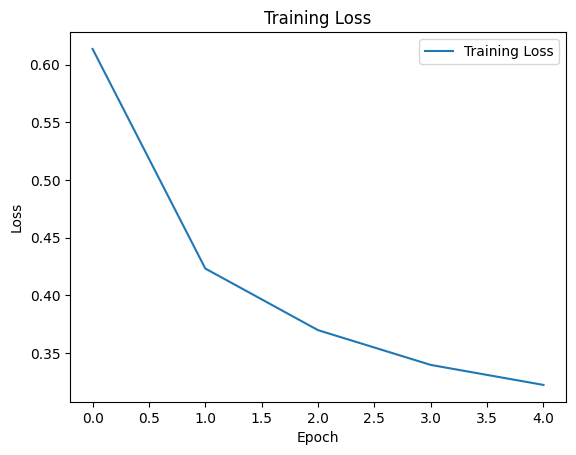

In [14]:
plt.plot(train_losses, label='Training Loss')
plt.title("Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

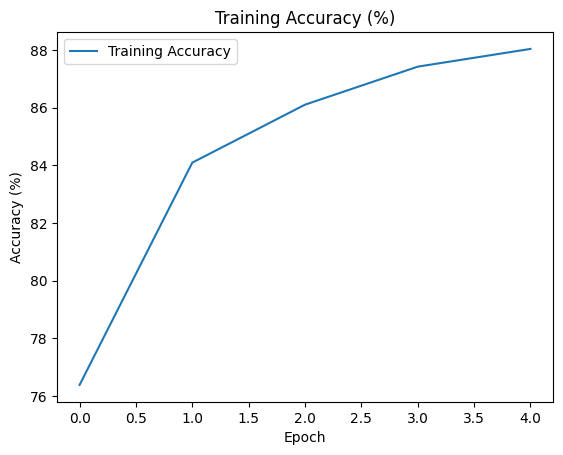

In [15]:
train_acc = [correct / len(train_data) * 100 for correct in train_correct]

plt.plot(train_acc, label='Training Accuracy')
plt.title('Training Accuracy (%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

#Save & Load Model:

In [16]:
# Save model's parameters
torch.save(model.state_dict(), 'LeNet_FashionMNIST.pt')

In [17]:
# Load model's parameters
model = LeNet() # create an instance of model
model.load_state_dict(torch.load('LeNet_FashionMNIST.pt'))
model.eval()

<ipython-input-17-d060cb80d040>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('LeNet_FashionMNIST.pt'))


LeNet(
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
)

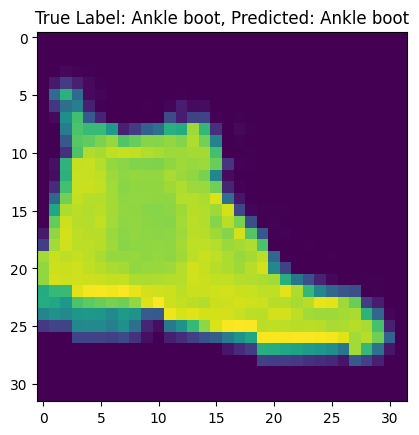

In [18]:
#Test Manually
img_num = 123

img_tensor, true_label = test_data[img_num]

img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(32, 32))

with torch.no_grad():
    output = model(img_tensor)
    _, predicted_label = torch.max(output, 1)

labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.imshow(img_tensor.squeeze())
plt.title(f"True Label: {labels[true_label]}, Predicted: {labels[predicted_label.item()]}")
plt.show()